# **PREVISÃO DE COTAÇÃO DE AÇÃO DA BOLSA DE VALORES COM LSTM e REDE NEURAL DENSA**

**OBJETIVO:**
- Realizar previsões de cotação da ação da empresa B3 na bolsa de valores brasileira através de deep learning utilizando um modelo de rede neural densa e o modelo de rede neural recorrente Long Short Term Memory (LSTM).
- Para isto, irei considerar as informações do ativo obtidas entre 01/01/2018 e 31/12/2020 e utilizarei o método window (janela temporal) para as predições.
- Ao final da aplicação dos dois métodos, poderemos visualizar qual apresentu melhores resultados através de métricas de acurácia MSE e RMSE.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as wb 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
import warnings
warnings.filterwarnings('ignore')
#mport os
#os.environ['CUDA_VISIBLE_DEVICES']='-1'

In [ ]:
# Carregando dados diários do ativo selecionado da web(Yahoo Finance): preços abertura e fechamento, mínima e máxima do dia, volume de negociações.
dados = wb.DataReader('B3SA3.SA', data_source='yahoo', start='01-01-2018', end='12-01-2020')
dados

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,23.340000,22.809999,22.889999,22.910000,9671100.0,20.610033
2018-01-03,23.420000,22.680000,22.750000,23.299999,6306700.0,20.960878
2018-01-04,23.600000,23.270000,23.370001,23.450001,5655100.0,21.095818
2018-01-05,23.790001,23.330000,23.400000,23.790001,7321600.0,21.401688
2018-01-08,24.180000,23.490000,23.750000,23.900000,6925200.0,21.500643
...,...,...,...,...,...,...
2020-11-25,56.730000,55.419998,55.639999,56.610001,11266400.0,55.372387
2020-11-26,57.099998,55.869999,56.290001,57.000000,7414000.0,55.753860
2020-11-27,57.290001,56.349998,57.099998,56.900002,10995800.0,55.656044


In [ ]:
df = pd.DataFrame(data=dados)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
dados.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
715,2020-11-25,56.730000,55.419998,55.639999,56.610001,11266400.0,55.372387
716,2020-11-26,57.099998,55.869999,56.290001,57.000000,7414000.0,55.753860
717,2020-11-27,57.290001,56.349998,57.099998,56.900002,10995800.0,55.656044
718,2020-11-30,57.000000,55.830002,56.599998,56.130001,21827700.0,54.902882
719,2020-12-01,57.189999,56.180000,56.799999,56.779999,10584600.0,55.538670


In [ ]:
dados.shape

(720, 7)

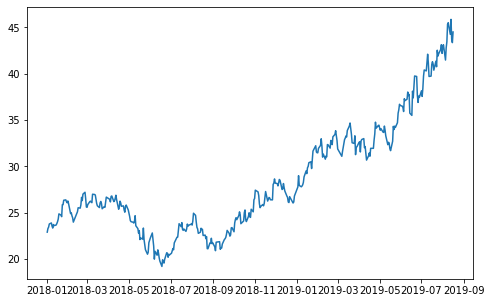

In [ ]:
# Mostrando o gráfico no período dos 3 primeiros anos (1950-1952)
x = dados['Date'][0:400]
y = dados['Close'][0:400]
plt.figure(figsize=(8, 5))
plt.plot(x,y)

In [ ]:
# Criando um dataset com os dados juntos (dados e fechamento) de x e y
dataset = pd.concat([x, y], axis=1)
dataset.columns =['x','y']

In [ ]:
#Criando bases de treino e teste:
tamanho_treino = int(len(dataset) * 0.70)  #70% para treino
treino, teste = dataset[0:tamanho_treino], dataset[tamanho_treino:len(dataset)]  #restante de 30% para teste

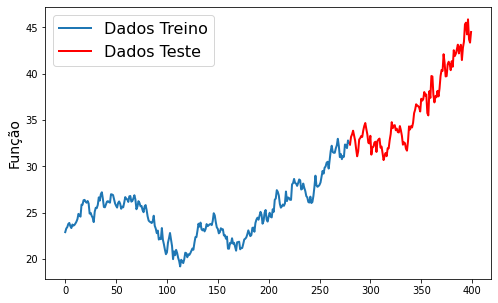

In [ ]:
# Mostrando quais dados servirão para treino e para teste
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.plot(treino['y'], label='Dados Treino', linewidth=2)
ax.plot(teste['y'], 'r', label='Dados Teste', linewidth=2,)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

In [ ]:
# Criando a função para agrupar os dados em windows (janelas temporais):
def gera_dataset(dataset, tamanho_janela = 1):
    dataA, dataB = [], []
    for i in range(len(dataset)-tamanho_janela): 
        a = dataset.loc[(dataset.index[0]+i):(dataset.index[0]+i+tamanho_janela-1)]['y'].values #Definindo o ponto inicial com loc e seu limite de alcance
        dataA.append(a)      #Variavel preditora
        dataB.append(dataset.loc[[dataset.index[0]+i+tamanho_janela]]['y'].values)   #Variavel target
    return np.asarray(dataA, dtype=np.float32), np.asarray(dataB, dtype=np.float32)

In [ ]:
# Aplicando a função nos datasets de treino e teste já criados:
tamanho_janela=10
x_treino, y_treino = gera_dataset(treino, tamanho_janela=tamanho_janela)
x_teste, y_teste = gera_dataset(teste, tamanho_janela=tamanho_janela)

In [ ]:
x_treino.shape

(270, 10)

**PREVISÕES COM REDE NEURAL DENSA**

In [ ]:
# Criando a rede densa utilizando o tamanho da janela como nº neurônios de entrada, 2 camadas ocultas 30 neurônios e 1 camada de saída:
modelo = Sequential()

# Camada de entrada + camada oculta
modelo.add(Dense(30, input_dim = tamanho_janela, activation = 'relu'))
modelo.add(Dense(30, activation = 'relu'))
modelo.add(Dense(30, activation='relu'))
# Camada de saída
modelo.add(Dense(1, kernel_initializer='normal', activation='linear'))

In [ ]:
#Compilando o modelo utilizando MSE como métrica e Adam como otimizador:
modelo.compile(loss = 'mean_squared_error', optimizer = 'adam')
modelo.fit(x_treino, y_treino, epochs = 100, batch_size = 2, verbose = 1)

Epoch 1/100
135/135 [==============================] - 1s 1ms/step - loss: 319.2585
Epoch 2/100
135/135 [==============================] - 0s 1ms/step - loss: 0.8422
Epoch 3/100
135/135 [==============================] - 0s 1ms/step - loss: 0.9258
Epoch 4/100
135/135 [==============================] - 0s 1ms/step - loss: 0.8137
Epoch 5/100
135/135 [==============================] - 0s 1ms/step - loss: 0.9632
Epoch 6/100
135/135 [==============================] - 0s 1ms/step - loss: 0.9167
Epoch 7/100
135/135 [==============================] - 0s 1ms/step - loss: 1.0032
Epoch 8/100
135/135 [==============================] - 0s 1ms/step - loss: 0.8676
Epoch 9/100
135/135 [==============================] - 0s 1ms/step - loss: 0.8101
Epoch 10/100
135/135 [==============================] - 0s 1ms/step - loss: 0.9790
Epoch 11/100
135/135 [==============================] - 0s 1ms/step - loss: 0.9593
Epoch 12/100
135/135 [==============================] - 0s 1ms/step - loss: 0.8667
Epoch 13/10

In [ ]:
# Calculando a performance do modelo
score_treino = modelo.evaluate(x_treino, y_treino, verbose = 0)
print('Resultado Treino -', 'MSE:', score_treino, 'RMSE:', math.sqrt(score_treino))
score_teste = modelo.evaluate(x_teste, y_teste, verbose = 0)
print('Resultado Teste -','MSE:', score_teste, 'RMSE:', math.sqrt(score_teste))

Resultado Treino - MSE: 0.42424270510673523 RMSE: 0.6513391628842344
Resultado Teste - MSE: 0.9136756062507629 RMSE: 0.9558638010986518


In [ ]:
# Gerando previsões para mostrar no gráfico
previsoes = modelo.predict(x_teste)

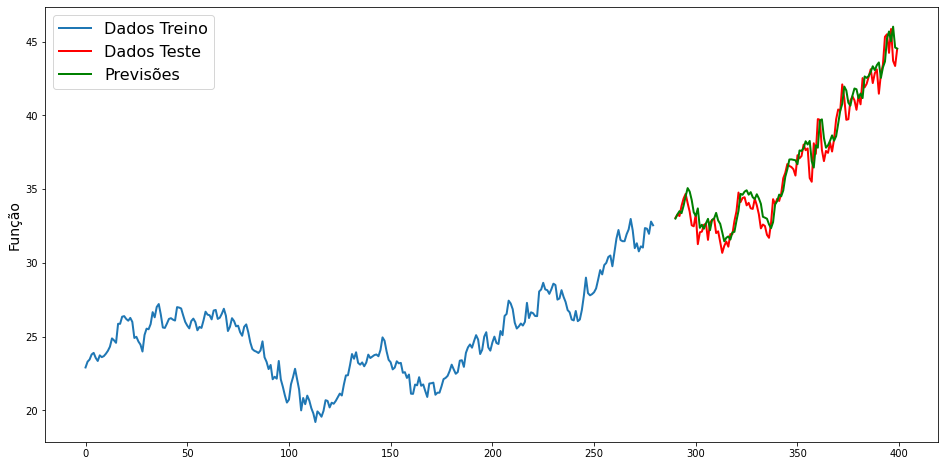

In [ ]:
# Plotando os valores previstos pelo modelo juntamente com os valores reais:
previsto = teste[tamanho_janela:].copy()  
previsto['y'] = previsoes 
fig, ax = plt.subplots(1, figsize=(16,8))
ax.plot(treino['y'], label='Dados Treino', linewidth=2)
ax.plot(teste['y'][10:], 'r', label='Dados Teste', linewidth=2)
ax.plot(previsto['y'], 'g', label='Previsões', linewidth=2)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

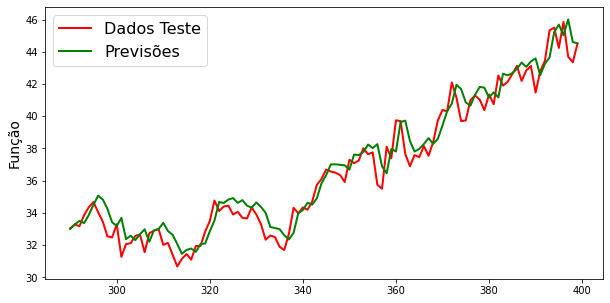

In [ ]:
# Olhando especificamente dados de teste e de previsões:
previsto = teste[tamanho_janela:].copy()  
previsto['y'] = previsoes 
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(teste['y'][10:], 'r', label='Dados Teste', linewidth=2)
ax.plot(previsto['y'], 'g', label='Previsões', linewidth=2)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

**PREVISÕES COM LSTM**

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt

In [ ]:
# Normalizando dados:

from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
# Normalizando os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset['y'] = scaler.fit_transform(dataset['y'].values.reshape(-1,1))

#70% para treino e 30% para teste
tamanho_treino = int(len(dataset) * 0.7)
treino, teste = dataset[0:tamanho_treino], dataset[tamanho_treino:len(dataset)]

In [ ]:
# Aplicando a função nos datasets de treino e teste que já criamos:
tamanho_janela=10
x_treino, y_treino = gera_dataset(treino, tamanho_janela=tamanho_janela)
x_teste, y_teste = gera_dataset(teste, tamanho_janela=tamanho_janela)

# Reshape do input (colocando os dados temporais como features):
x_treino = np.reshape(x_treino, (x_treino.shape[0], x_treino.shape[1], 1)) # pega o dataset x_treino e coloca no formato:
# [n_amostras, n_timesteps, n_features]. O resultado dessa operação será os dados do dataset x_treino com essas 3 dimensões.
x_teste = np.reshape(x_teste, (x_teste.shape[0], x_teste.shape[1], 1))

In [ ]:
print(x_treino.shape)
print(x_teste.shape)

(270, 10, 1)
(110, 10, 1)


In [ ]:
# Criando o modelo LSTM:
modelo2 = Sequential()
modelo2.add(LSTM(4, batch_input_shape = (2, x_treino.shape[1], x_treino.shape[2]), stateful = True))

modelo2.add(Dense(1)) # Saída da LSTM
modelo2.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [ ]:
modelo2.fit(x_treino, y_treino, epochs=100, batch_size=2, verbose=2)

Epoch 1/100
135/135 - 2s - loss: 0.0111
Epoch 2/100
135/135 - 0s - loss: 0.0038
Epoch 3/100
135/135 - 0s - loss: 0.0022
Epoch 4/100
135/135 - 0s - loss: 0.0017
Epoch 5/100
135/135 - 0s - loss: 0.0015
Epoch 6/100
135/135 - 0s - loss: 0.0013
Epoch 7/100
135/135 - 0s - loss: 0.0013
Epoch 8/100
135/135 - 0s - loss: 0.0013
Epoch 9/100
135/135 - 0s - loss: 0.0012
Epoch 10/100
135/135 - 0s - loss: 0.0012
Epoch 11/100
135/135 - 0s - loss: 0.0012
Epoch 12/100
135/135 - 0s - loss: 0.0012
Epoch 13/100
135/135 - 0s - loss: 0.0011
Epoch 14/100
135/135 - 0s - loss: 0.0011
Epoch 15/100
135/135 - 0s - loss: 0.0011
Epoch 16/100
135/135 - 0s - loss: 0.0011
Epoch 17/100
135/135 - 0s - loss: 0.0010
Epoch 18/100
135/135 - 0s - loss: 0.0010
Epoch 19/100
135/135 - 0s - loss: 9.7135e-04
Epoch 20/100
135/135 - 0s - loss: 9.4973e-04
Epoch 21/100
135/135 - 0s - loss: 9.2454e-04
Epoch 22/100
135/135 - 0s - loss: 9.1732e-04
Epoch 23/100
135/135 - 0s - loss: 9.1016e-04
Epoch 24/100
135/135 - 0s - loss: 8.6187e-04
E

In [ ]:
from sklearn.metrics import mean_squared_error
previsoes2 = modelo2.predict(x_teste, batch_size = 2)

In [ ]:
# Calculando a performance do modelo
score_treino2 = modelo2.evaluate(x_treino, y_treino, batch_size=2, verbose=1)
score_teste2 = modelo2.evaluate(x_teste, y_teste, batch_size=2, verbose=1)

55/55 [==============================] - 0s 1ms/step - loss: 0.0011


In [ ]:
#Visualizando performance do modelo acima:
print('Resultado Treino -', 'MSE:', score_treino2, 'RMSE:', math.sqrt(score_treino2))
print('Resultado Teste -', 'MSE:', score_teste2, 'RMSE:', math.sqrt(score_teste2))

Resultado Treino - MSE: 0.0004698570119217038 RMSE: 0.021676185363705115
Resultado Teste - MSE: 0.0010963843669742346 RMSE: 0.03311169532014685


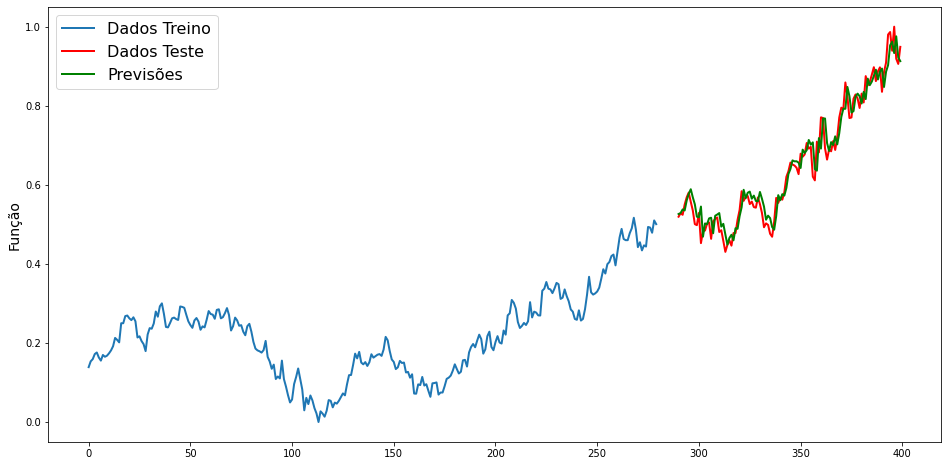

In [ ]:
# Plotando os valores previstos pelo modelo juntamente com os valores reais:
previsto2 = teste[tamanho_janela:].copy()  
previsto2['y'] = previsoes2 
fig, ax = plt.subplots(1, figsize=(16,8))
ax.plot(treino['y'], label='Dados Treino', linewidth=2)
ax.plot(teste['y'][10:], 'r', label='Dados Teste', linewidth=2)
ax.plot(previsto2['y'], 'g', label='Previsões', linewidth=2)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

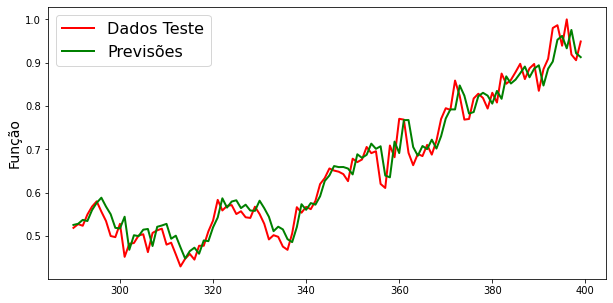

In [ ]:
# Olhando especificamente dados de teste e de previsões:
previsto2 = teste[tamanho_janela:].copy()  
previsto2['y'] = previsoes2
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(teste['y'][10:], 'r', label='Dados Teste', linewidth=2)
ax.plot(previsto2['y'], 'g', label='Previsões', linewidth=2)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

**FIM**